# KNN Classifier

In [1]:
import numpy as np
import pandas as pd
from pylab import plt
from enum import Enum 
plt.style.use('seaborn')
%matplotlib inline
from pandas_datareader import data as web

# 1. Feature Extraction and Pre Processing

### 1.1 Utility methods and classes for feature extraction

 Feature class containing  possible features which are supported

In [2]:
class Feature(Enum):
    OHLC           = 1
    LAGGED_RETURNS = 2
    SMA_PRICE      = 3
    SMA_VAR        = 4
    RSI            = 5
    MACD           = 6
    EWMA_PRICE     = 7
    EWMA_VAR       = 8
    VAR            = 9

### 1.2 Gaussian method
Gaussian method to normalize and transform the data to zero mean

In [3]:
def gaussian(xa):
    x = xa.copy()
    mean = x.mean()
    std = x.std()
    return (x - mean) / std, mean, std

## 1.3 RSI Feature

### [TBD] Add theory

In [4]:
def RSI(series, period, normalize = True):
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 #rs = pd.stats.moments.ewma(u, com=period-1, adjust=False) / \
 #pd.stats.moments.ewma(d, com=period-1, adjust=False)
 
 rs = u.ewm(span=period-1, adjust=False).mean() / d.ewm(span=period-1, adjust=False).mean()

 rsi = 100 - 100 / (1 + rs)
 
 if normalize:
  rsi, mean, std  = gaussian(rsi)

 #print('u.shape ={}'.format(u.shape))
 #print('d.shape ={}'.format(d.shape))
 #print('rs.shape ={}'.format(rs.shape))
 #print('rsi.shape ={}'.format(rsi.shape))

 return rsi

### 1.4 MACD Feature

In [5]:
def MACD(series, period, normalize = True):
 exp1 = series.ewm(span=12, adjust=False).mean()
 exp2 = series.ewm(span=26, adjust=False).mean()
 macd = exp1-exp2
 
 if normalize:
  macd, mean, std = gaussian(macd)

 return macd

### 1.5 get_data: An utility method that encapsulates historical price  download and the feature extraction 
<b>Input Arguments:</b><br>
features = This is a list of values from Feature type class, it contains the type of features to be extracted.<br>
normalize = A Boolean variable specifying if the feature values to be normalized (zero mean)

<b>Return Values:</b> <br>
Returns the features

In [6]:
def get_data(features, normalize = True):
    # Download the histo market data
    # Extract the Features
    # Returns Featurs and columns
    data = pd.DataFrame(web.DataReader('AMZN', data_source='yahoo')[['High', 'Low', 'Open', 'Close']])
    data.columns = ['h', 'l', 'o', 'c']
    cols = []
    
    # The log return
    data['returns'] = np.log(data['c'] / data['c'].shift(1))
    # Return Sign
    data['d'] = np.where(data['returns'] > 0, 1, -1)
    #print('before count={}'.format(data.count()))
    LAGS = 5
    if Feature.OHLC in features:
        data['h-l'] = data['h'] - data['l']
        data['c-o'] = data['c'] - data['o']
        cols.append('c-o')
        cols.append('h-l')
    if Feature.LAGGED_RETURNS in features:
        for lag in range(1, LAGS+1):
            col = 'ret_%d' % lag
            data[col] = data['returns'].shift(lag)
            cols.append(col)
    if Feature.SMA_PRICE in features: 
        data['sma10'] = data['c'].rolling(10).mean() # Simple moving average
        data['sma25'] = data['c'].rolling(25).mean()
        cols.append('sma10')
        cols.append('sma25')
    if Feature.SMA_VAR in features: 
        data['var10'] = data['c'].rolling(10).std() # Simple moving average
        data['var25'] = data['c'].rolling(25).std()
        cols.append('var10')
        cols.append('var25')
    if Feature.RSI in features: 
        data['rsi'] = RSI(data['c'], 10, False)
        cols.append('rsi')
    if Feature.MACD in features: 
        data['macd'] = MACD(data['c'], 10, False)
        cols.append('macd')
    if Feature.EWMA_PRICE in features: 
        data['ewma'] = data['c'].ewm(span=20, adjust=False).mean()
        cols.append('ewma')
    if Feature.EWMA_VAR in features: 
        data['ewmstd'] = data['c'].ewm(span=20, adjust=False).std()
        cols.append('ewmstd')
    
  
    data.dropna(inplace=True)
    #print('after count={}'.format(data.count()))
    # Get the gaussian of all the values - so that we have normalized the data.
    if normalize:
       for col in cols:
           data[col], mean, std = gaussian(data[col])
        
    return data, cols

In [7]:
data, cols = get_data(
    [Feature.OHLC,  
     Feature.LAGGED_RETURNS,  
     Feature.SMA_PRICE,  
     Feature.SMA_VAR,  
     Feature.RSI,  
     Feature.MACD, 
     Feature.EWMA_PRICE,  
     Feature.EWMA_VAR])

In [8]:
#data.count()

## 2 KNN Classifier

## 2.1 Model train and validation on the trained data set

In [9]:
from sklearn.neighbors import KNeighborsClassifier

In [10]:
knn = KNeighborsClassifier(n_neighbors = 3)

In [11]:
%time knn.fit(data[cols], data['d'])

Wall time: 3.99 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [12]:
data['p'] = knn.predict(data[cols])
#data['p'].value_counts()

In [13]:
data['p'] = np.where(data['p'] > 0, 1, -1)

In [14]:
data['s'] = data['p'] * data['returns']

In [15]:
data[['returns', 's']].sum().apply(np.exp)

returns    1.734518e+01
s          2.955113e+12
dtype: float64

In [16]:
data[['returns', 's']].sum().apply(np.exp)

returns    1.734518e+01
s          2.955113e+12
dtype: float64

In [17]:
print('Training score:', knn.score(data[cols], data['d']))

Training score: 0.8875315922493682


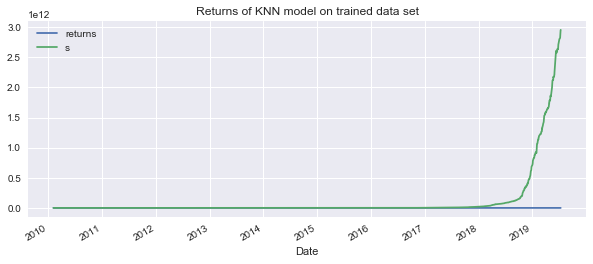

In [18]:
data[['returns', 's']].cumsum().apply(np.exp).plot(figsize=(10, 4),
                   title="Returns of KNN model on trained data set");

<b>Summary:</b>: 

In [19]:
print('Training accuracy:', knn.score(data[cols], data['d']))

Training accuracy: 0.8875315922493682


## 2.2 Model train and validation on the test data set

The data we use is usually split into training data and test data. The training set contains a known output and the model learns on this data in order to be generalized to other data later on. We have the test dataset (or subset) in order to test our model’s prediction on this subset.

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
from sklearn import model_selection
train, test = model_selection.train_test_split(data, test_size=0.2, shuffle=False)

In [22]:
train = train.copy()
test = test.copy()

In [23]:
print("Train count {}, Test count {}".format(len(train), len(test)))

Train count 1899, Test count 475


In [24]:
knn2 = KNeighborsClassifier(n_neighbors = 3)

In [25]:
%time knn2.fit(train[cols], train['d'])

Wall time: 0 ns


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [26]:
test['p'] = knn2.predict(test[cols])
#test['p'].value_counts()

In [27]:
test['p'] = np.where(test['p'] > 0, 1, -1)

In [28]:
test['s'] = test['p'] * test['returns']

In [29]:
test[['returns', 's']].sum().apply(np.exp)

returns      2.109536
s          182.255880
dtype: float64

In [30]:
test[['returns', 's']].sum().apply(np.exp)

returns      2.109536
s          182.255880
dtype: float64

In [31]:
print('Accuracy on Test data set:', knn2.score(test[cols], test['d']))

Accuracy on Test data set: 0.7978947368421052


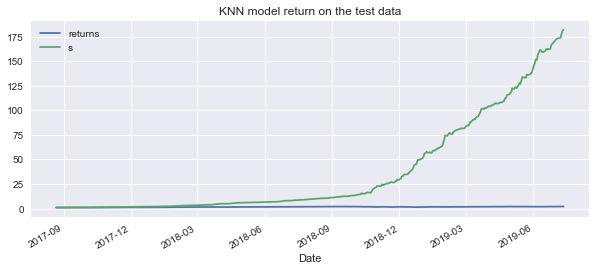

In [32]:
test[['returns', 's']].cumsum().apply(np.exp).plot(figsize=(10, 4), 
       title="KNN model return on the test data");

<b>Summary:</b>: The prediction accuracy on the Trained data set turned out to be 86%

## 3. Precision Recall

<b>Precision</b> is the ability to not label a sample as positive if it is negative. 

<b>Recall</b> is the ability of the classifier to find all the positive samples. The recall is the number of instances from the first class that actually predicted correctly

The <b>F-beta score</b> weights the recall more than the precision by a factor of beta. beta = 1.0 means recall and
precision are equally important. F-beta score reaches its best value at 1 and worst score at 0.


In [33]:
from sklearn.metrics import classification_report

In [34]:
data['d'].value_counts()
data['p'] = knn.predict(data[cols])

In [35]:
print(classification_report(data['d'], data['p']))

             precision    recall  f1-score   support

         -1       0.88      0.88      0.88      1104
          1       0.90      0.89      0.89      1270

avg / total       0.89      0.89      0.89      2374



# 4. Confusion Matrix

Allows to look into accuracy of prediction within each class. TO BE READ ON DIAGONAL (visualisation
below)
<br>
Predicted NegativeReturns that were actually NegativeReturns (-1):
<br>
Predicted PositiveReturns that were actually PositiveReturns (1):
<br>

In [36]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(data['d'], data['p'], labels=[-1,1])
print(confusion_matrix)
'''
The lables=[-1,1] indicates the confusion_matrix ordering of the output in the order [-1,1] predicted values
'''

[[ 971  133]
 [ 134 1136]]


'\nThe lables=[-1,1] indicates the confusion_matrix ordering of the output in the order [-1,1] predicted values\n'

In [37]:
data['d'].value_counts()

 1    1270
-1    1104
Name: d, dtype: int64

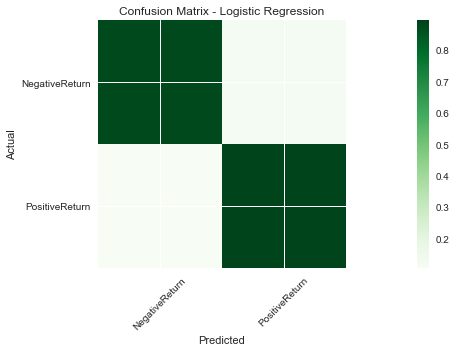

In [38]:
# function for plotting confusion matrix
def plot_cm(cm, target_names, title,
    cmap=plt.cm.Greens):
    cm_norm = cm * 1. / cm.sum(axis=1)[:, np.newaxis] # standardize the confusion matrix
    plt.imshow(cm_norm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    ticks = np.arange(len(target_names))
    plt.xticks(ticks, target_names, rotation=45)
    plt.yticks(ticks, target_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.tight_layout()

plt.clf
plt.figure(figsize=(20, 5), facecolor='w')
plt.subplot(111)
plot_cm(confusion_matrix, ['NegativeReturn','PositiveReturn'], 'Confusion Matrix - Logistic Regression')
plt.show()


# 5. K-Fold - CrossValidation

<b> Crossvalidation </b> attempts to avoid overfitting while still producing a prediction for each observation.

<b>KFold</b> splits dataset into k consecutive folds. (K-1) subsets to are used to train the classifier, while the
the last subset (or the last fold) is our test data.

In [39]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score

In [40]:
kfold = model_selection.KFold(n_splits=5, random_state=7, shuffle=False) # RandomState is the seed used by the RNG
print(kfold)
print()
crossval = model_selection.cross_val_score(knn, data[cols], data['d'], cv=kfold, scoring='accuracy')
print("5-fold crossvalidation accuracy: %.4f" % (crossval.mean())) #average accuracy


KFold(n_splits=5, random_state=7, shuffle=False)

5-fold crossvalidation accuracy: 0.7721


#### K-Fold with Shuffle

1. Shuffle the dataset randomly.<br>
2. Split the dataset into k groups <br>
3. For each unique group: <br>
   a. Take the group as a hold out or test data set <br>
   b. Take the remaining groups as a training data set <br>
   c. Fit a model on the training set and evaluate it on the test set <br>
   d. Retain the evaluation score and discard the model <br>
4. Summarize the skill of the model using the sample of model evaluation scores

In [41]:
kfold = model_selection.KFold(n_splits=5, random_state=7, shuffle=True) # RandomState is the seed used by the RNG
print(kfold)
print()
crossval = model_selection.cross_val_score(knn, data[cols], data['d'], cv=kfold, scoring='accuracy')
print("5-fold crossvalidation accuracy: %.4f" % (crossval.mean())) #average accuracy

KFold(n_splits=5, random_state=7, shuffle=True)

5-fold crossvalidation accuracy: 0.7864


## 6. Perform the process to find right value of K 

##### Hypertuning model parameters using GridSearchCV

When built our initial k-NN model, we set the parameter ‘n_neighbors’ to 3 as a starting point with no real logic behind that choice.
Hypertuning parameters is when you go through a process to find the optimal parameters for your model to improve accuracy. In our case, we will use GridSearchCV to find the optimal value for ‘n_neighbors’.


In [42]:
from sklearn.model_selection import GridSearchCV


In [43]:
#create new a knn model
knn2 = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)
#fit model to data
knn_gscv.fit(data[cols], data['d'])

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [44]:
#check top performing n_neighbors value
knn_gscv.best_params_

{'n_neighbors': 17}

In [45]:
#check mean score for the top performing value of n_neighbors
knn_gscv.best_score_

0.7940185341196293